**Importing Libraries**

In [ ]:
!pip install pmdarima
import pmdarima
import pandas as pd
import csv
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import re  #For stemming
import nltk  #For stop words (The, and, hi)
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
nltk.download('wordnet')
nltk.download('punkt')
#To display full output.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
warnings. filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive/')

Reading dataset

In [ ]:
prices=pd.read_csv("/content/drive/MyDrive/Intern/Prices.csv")
headline=pd.read_csv("/content/drive/MyDrive/Intern/Headlines.csv",quoting=csv.QUOTE_NONE,encoding='utf8')
print(prices.shape,headline.shape)

(122, 7) (3297172, 3)


In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       122 non-null    object 
 1   Open       122 non-null    float64
 2   High       122 non-null    float64
 3   Low        122 non-null    float64
 4   Close      122 non-null    float64
 5   Adj Close  122 non-null    float64
 6   Volume     122 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 6.8+ KB


In [ ]:
headline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


In [ ]:
headline.tail().T

,3297167,3297168,3297169,3297170,3297171
publish_date,20200630,20200630,20200630,20200630,20200630
headline_category,gadgets-news,entertainment.hindi.bollywood,entertainment.hindi.bollywood,entertainment.hindi.bollywood,entertainment.telugu.movies.news
headline_text,"""why tiktok removed 1 65 crore videos in india""","""apurva asrani calls alia bhatts mother soni razdans views on sushant singh rajputs demise untrue""","""kangana ranaut gets a doll version of herself her team shares manikarnika dolls are the new favourite for children""","""meezaan jaffrey reminisces his childhood days with his grandfather jagdeep with an adorable throwback picture""","""prabhas20 titled as radhe shyam prabhas and pooja hegde strike a romantic pose in the first look"""


In [ ]:
headline['publish_date']=pd.to_datetime(headline['publish_date'], format='%Y%m%d') 


#Keeping only relevant categories

In [ ]:
#Keeping only relevant categories
text=headline[(headline['headline_category']=='business.personal-finance') |
              (headline["headline_category"]=='analysis') |
              (headline["headline_category"]=='business') |
              (headline["headline_category"]=='ambani') |
              (headline["headline_category"]=='pm-on-china-visit.news') |
              (headline["headline_category"]=='business.international-business') |
              (headline["headline_category"]=='business.india-business')]
text=text.drop(["headline_category"], axis=1)
text.shape


(153805, 2)

#Distributing in years

In [ ]:

y1 = text[text['publish_date'].map(lambda x : x.year == 2001)]
y2 = text[text['publish_date'].map(lambda x : x.year == 2002)]
y3 = text[text['publish_date'].map(lambda x : x.year == 2003)]
y4 = text[text['publish_date'].map(lambda x : x.year == 2004)] 
y5 = text[text['publish_date'].map(lambda x : x.year == 2005)] 
y6 = text[text['publish_date'].map(lambda x : x.year == 2006)]
y7 = text[text['publish_date'].map(lambda x : x.year == 2007)]
y8 = text[text['publish_date'].map(lambda x : x.year == 2008)]
y9 = text[text['publish_date'].map(lambda x : x.year == 2009)]
y10= text[text['publish_date'].map(lambda x : x.year == 2010)]

#Appending daily news into monthly news.

In [ ]:
jj=[]
for i in y1,y2,y3,y4,y5,y6,y7,y8,y9,y10:
    jj.append(i.groupby(i['publish_date'].map(lambda x: x.month))['headline_text'].apply(','.join).reset_index())

In [ ]:
li=[]
for i in jj:
    li.append(i)
    all_dat = pd.concat(li ,axis=0, ignore_index = True)
all_dat.shape

(117, 2)

**Removing price change of 2001 months of 2,3,4 and price change of 2011**

In [ ]:

prices=prices[~(prices['Date'] == '2001-02-01')]
prices=prices[~(prices['Date'] == '2001-03-01')]
prices=prices[~(prices['Date'] == '2001-04-01')] 
prices=prices[~(prices['Date'] == '2011-01-01')]
prices=prices[~(prices['Date'] == '2011-02-01')]

prices["Change"]=prices.Open-prices.Close
prices.shape

(117, 8)

In [ ]:
prices.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Change       0
dtype: int64

#Creating our final DataFrame

In [ ]:
change=[]
for i in prices["Change"]:
  if i > 0:
    change.append("Positive")
  elif i == 0:
    change.append("No change")
  else:
    change.append("Negative")
prices = prices.reset_index(drop=True)
all_dat = all_dat.reset_index(drop=True)
all_dat.publish_date=prices.Date
all_dat["Result"]=pd.DataFrame(change)
all_dat["Change"]=prices.Change
all_dat.isnull().sum()

publish_date     0
headline_text    0
Result           0
Change           0
dtype: int64

#Dropping dataFrames

In [ ]:
del jj,li,text,headline,i,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,change,prices

In [ ]:
all_dat.head()
#Removing 1st row 
all_dat=all_dat.iloc[1:]
all_dat = all_dat.reset_index(drop=True)
all_dat.shape

(116, 4)

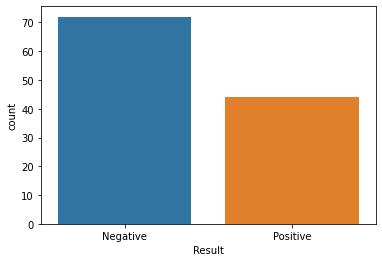

In [ ]:
sns.countplot(x ='Result', data = all_dat)

#Text Cleaning

In [ ]:
corpus = []
for i in range(0, len(all_dat)):
  review = re.sub('[^a-zA-Z]', ' ', all_dat["headline_text"][i]) #Removing Punctualtion
  review = re.sub(r'\s+',' ',review) ##To remove extra spaces
  review = review.lower()  #Changing it to lower case
  review = re.sub(r'\b\w{1,3}\b', '', review)
  review = review.split()  #Splitting word
  wl = WordNetLemmatizer()  #Lemmatizing (Loving/Loved->Love)
  all_stopwords = stopwords.words('english') #Removing (Then, they, I, has)
  review = [wl.lemmatize(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

**Making NLP model**

In [ ]:
#Making sparse MATRIX
from sklearn.feature_extraction.text import TfidfVectorizer
CV=TfidfVectorizer(max_features=300)#Taking most frequent words, removing those who appeared least
x=CV.fit_transform(corpus).toarray()
y=all_dat['Result']
x.shape
CV.vocabulary_


{'acquire': 0,
 'acquires': 1,
 'ahead': 2,
 'airline': 3,
 'airport': 4,
 'ambani': 5,
 'among': 6,
 'anil': 7,
 'april': 8,
 'asia': 9,
 'asian': 10,
 'asks': 11,
 'asset': 12,
 'auto': 13,
 'award': 14,
 'back': 15,
 'bag': 16,
 'bajaj': 17,
 'bank': 18,
 'banking': 19,
 'bharti': 20,
 'bhel': 21,
 'bid': 22,
 'bike': 23,
 'bill': 24,
 'billion': 25,
 'birla': 26,
 'block': 27,
 'board': 28,
 'bond': 29,
 'boost': 30,
 'brand': 31,
 'bsnl': 32,
 'budget': 33,
 'business': 34,
 'buy': 35,
 'buying': 36,
 'call': 37,
 'capital': 38,
 'car': 39,
 'card': 40,
 'case': 41,
 'cent': 42,
 'centre': 43,
 'change': 44,
 'charge': 45,
 'chief': 46,
 'china': 47,
 'chinese': 48,
 'clear': 49,
 'close': 50,
 'coal': 51,
 'come': 52,
 'company': 53,
 'cost': 54,
 'court': 55,
 'credit': 56,
 'crisis': 57,
 'crore': 58,
 'cross': 59,
 'crude': 60,
 'cue': 61,
 'cut': 62,
 'deal': 63,
 'debt': 64,
 'decline': 65,
 'delhi': 66,
 'demand': 67,
 'deposit': 68,
 'diesel': 69,
 'dip': 70,
 'dividend': 

**Applying Support Vector Classifier**

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.9)


**Defining the grid of hyperparameters to search**

In [ ]:
param_grid = [    
    {'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    }
]
# Training the SVM model on the Training set
from sklearn.svm import SVC
classifier = SVC()
from sklearn.model_selection import GridSearchCV
random_cv = GridSearchCV(estimator=classifier,
            param_grid=param_grid,
            cv=3,
            n_jobs = 1,
            verbose= 4 , 
            return_train_score = True)
best=random_cv.fit(x_train,y_train)
best.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV]  C=0.1, gamma=1, kernel=linear, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV]  C=0.1, gamma=1, kernel=linear, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV]  C=0.1, gamma=1, kernel=linear, score=(train=1.000, test=0.000), total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=(train=1.000, test=0.000), total=   0.0s
[CV] C=0.1, gamm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, gamma=1, kernel=poly, score=(train=0.857, test=0.500), total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV]  C=1, gamma=1, kernel=poly, score=(train=1.000, test=0.000), total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV]  C=1, gamma=1, kernel=sigmoid, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV]  C=1, gamma=1, kernel=sigmoid, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV]  C=1, gamma=1, kernel=sigmoid, score=(train=1.000, test=0.000), total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV]  C=1, gamma=0.1, kernel=linear, score=(train=0.571, test=0.500), total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV]  C=1, gamma=0.1, kernel=linear, score=(train=0.571, test=0.500), total=   0.

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

#The best model


In [ ]:
classifier = SVC(C=0.1, gamma=1, kernel='linear')
classifier.fit(x_train, y_train)
pred=classifier.predict(x_test)
accuracy_score(y_test, pred)

0.6285714285714286

**NUMERICAL ANALYSIS**

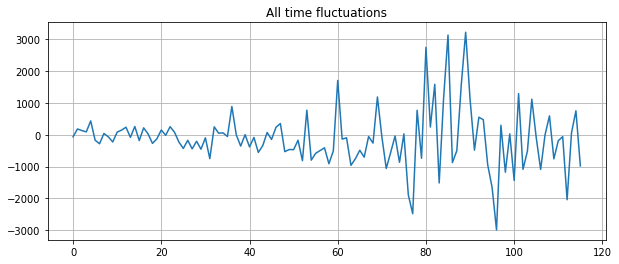

In [ ]:
tsa=pd.DataFrame({'Date':all_dat.publish_date, 'Change':all_dat.Change})
tsa['Date']=pd.to_datetime(tsa['Date'], format='%Y-%m-%d') 
plt.figure(figsize=(10, 4))
plt.plot(tsa.Change)
plt.title('All time fluctuations')
plt.grid(True)
plt.show()

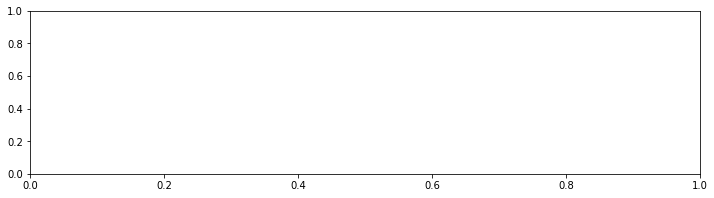

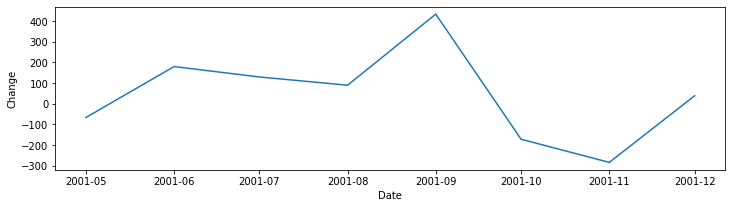

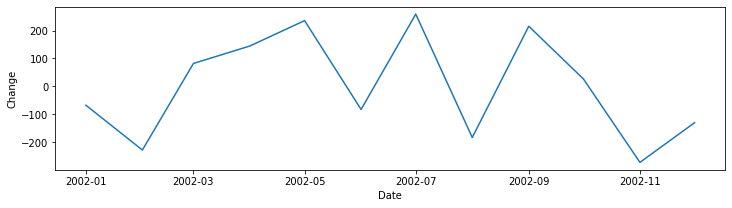

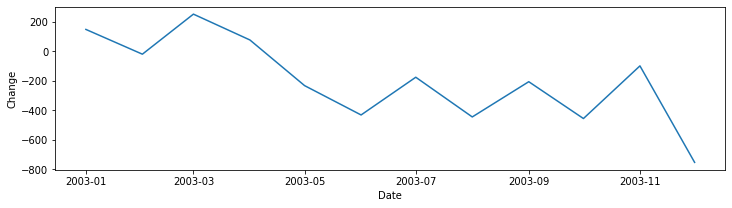

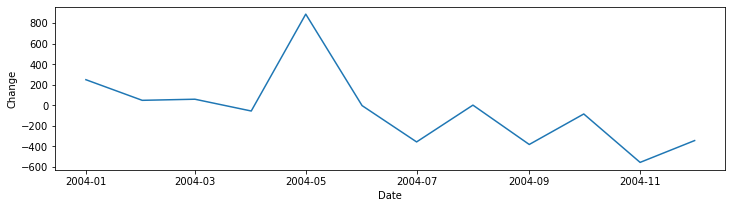

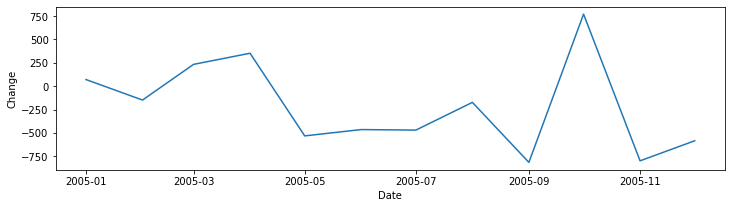

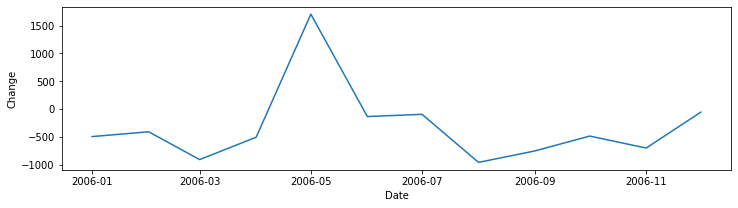

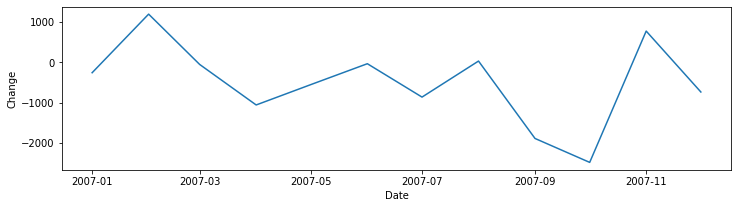

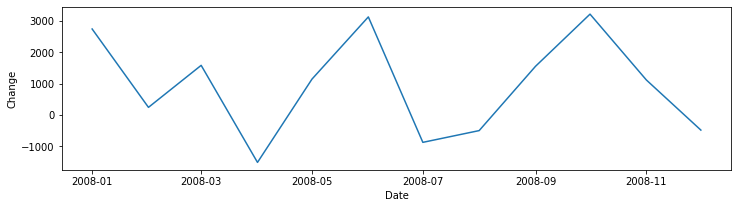

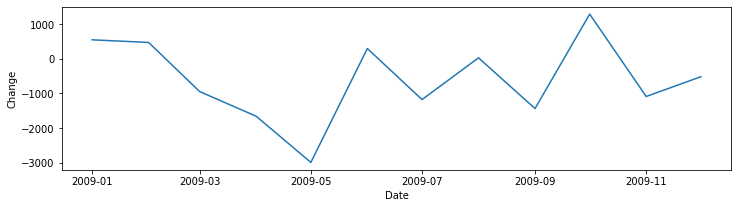

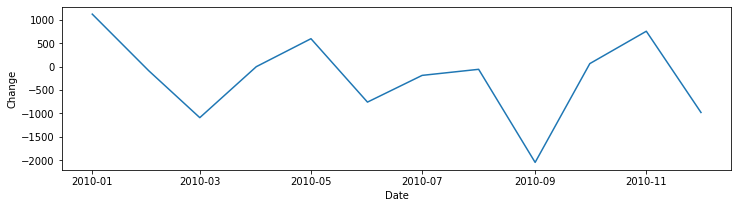

In [ ]:
for i in range(2000,2011):
  a4_dims = (12, 3)
  fig, ax = plt.subplots(figsize=a4_dims)
  sns.lineplot(x="Date", y="Change",
              data=tsa[tsa["Date"].map(lambda x : x.year == i)])

In [ ]:
x=tsa.iloc[:110,:]
y=tsa.iloc[110:116,:]

In [ ]:
model1=ARIMA(x['Change'],order=(0,0,8))
model1=model1.fit()

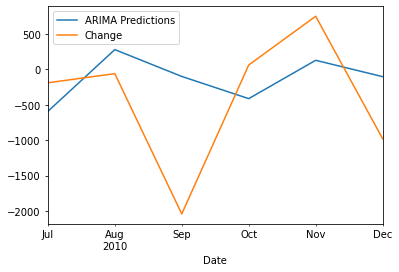

In [ ]:
start=len(x)
end=len(x)+len(y)-1
pred=model1.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
y['Change'].plot(legend=True)